In [1]:
# Standard Library
import os
import os.path as op
import sys
import platform
import glob
import re
import shutil
import time as tm
from pathlib import Path
import pickle

# Core Scientific Stack
import numpy as np
import numpy.matlib
import pandas as pd
import scipy.signal as sgn
import scipy.stats as sts
from scipy.stats import circmean, circvar, circstd
from astropy.stats import rayleightest, vtest, circcorrcoef
from scipy.io import savemat, loadmat

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import nilearn
from nilearn import plotting
from nilearn.plotting import plot_anat
from nilearn.image import new_img_like
from scipy.ndimage import gaussian_filter1d

# MNE & BIDS
import mne
from mne import viz
from mne.viz import plot_alignment
from mne.channels import make_standard_montage
from mne.datasets import eegbci
from mne_bids import (
    BIDSPath,
    read_raw_bids,
    write_raw_bids,
    write_anat,
    get_anat_landmarks,
    convert_montage_to_mri,
    convert_montage_to_ras,
    template_to_head,
    print_dir_tree,
    search_folder_for_text,
)
from mne_bids.stats import count_events
from mne import read_epochs
from mne.decoding import SlidingEstimator,GeneralizingEstimator

# Time-Frequency Analysis
import nitime.algorithms as tsa

# Machine Learning / Decoding
from sklearn.model_selection import LeaveOneOut, KFold, StratifiedKFold
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.svm import LinearSVR, SVC
from joblib import Parallel, delayed

# Deep Learning 
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Custom Toolbox
sys.path.append('/archive/intracranial/decoding_toolbox')  # Adjust if needed
import DecToolbox as dt

sys.path.append('/archive/intracranial/decoding_toolbox/Helper_funcs')
from base_stats import corr_linear_circular
from classifier_funcs import AngularRegression, SVR_polar, scorer_angle

# Other
import loess
from statsmodels.nonparametric.smoothers_lowess import lowess

import re
import nibabel as nib
from nilearn import plotting
from scipy.ndimage import gaussian_filter1d
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVR

2025-05-29 08:31:52.730859: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-29 08:31:52.732468: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-29 08:31:52.762508: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-29 08:31:52.787153: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748500312.813032  221035 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748500312.82

In [2]:
#ID_list = ['RP022023C', 'PB052023', 'LVM062023', 'VG102023', 'WAB112023C', 'MPCN012024C', 'MFA022024C', 'MB052024C', 'GG062024C', 'SH09292', 'M102024C', 'IBR0125C', 'APG0225C']
#participant_list = ['s02', 's03', 's04', 's05', 's06', 's07', 's08', 's10', 's11', 's12', 's13', 's14', 's15']

ID_list = ['WAB112023C','MFA022024C']
participant_list = ['s06','s08']

ID_list_tms = ['XXXX','AJ102022C','IM112022C']
participant_list_tms = ['S01','S03','S04']

Exp_Modality = 'iEEG'
Exp_ID = 'EXP01'
participant = 's06'
sub_participant = f"sub-{participant}"
ID ='WAB112023C'
subject_ID =  ID + participant
session_n = '01'
task_n = 'iEEGwmprior'

raw_epochs_filename_fif = f"epochs_raw_clean_{participant}prior-epo.fif"
artifact_detection_epochs_filename_fif = f"epochs_{participant}prior_cleaned-epo.fif"
auto_reject_epochs_filename_fif = f"autoreject_epochs_{participant}-epo.fif"

raw_epochs_filename_tms_fif = f"epochs_raw_clean_{participant}tms-epo.fif"
artifact_detection_epochs_filename_tms_fif = f"epochs_{participant}tms_cleaned-epo.fif"
auto_reject_epochs_filename_tms_fif = f"autoreject_epochs_{participant}-epo.fif"

In [3]:
sys_dir = os.path.join('/archive','intracranial') 
mne_dir = os.path.join(sys_dir,'Exp_3_WM_prior')  
ravecsv = os.path.join(sys_dir,'rave_data','data_dir','CLINIC_PATIENTS',ID,'rave','meta','electrodes.csv')
fs_dir = os.path.join(sys_dir,'rave_data','raw_dir',ID,'rave-imaging','fs') 
bids_dir = os.path.join(mne_dir, 'raw_BIDS')
preproc_dir = os.path.join(mne_dir,'Preproc',participant,'data')  
raw_clean_path = os.path.join(preproc_dir, "raw_clean.fif")
freesurfer_path = os.path.join('/home','intracranial','freesurfer') 

raw_epochs_path = os.path.join(mne_dir , 'analysis', 'epochs', 'Raw_Epochs',raw_epochs_filename_fif)
artifact_detection_epochs_path = os.path.join(mne_dir , 'analysis', 'epochs', 'Artifact_Detection_Epochs',artifact_detection_epochs_filename_fif)
auto_reject_epochs_path = os.path.join(mne_dir , 'analysis', 'epochs', 'Auto_Reject_Epochs',auto_reject_epochs_filename_fif)

raw_epochs_tms_path = os.path.join(mne_dir , 'analysis', 'epochs', 'Raw_Epochs',raw_epochs_filename_tms_fif)
artifact_detection_epochs_tms_path = os.path.join(mne_dir , 'analysis', 'epochs', 'Artifact_Detection_Epochs',artifact_detection_epochs_filename_tms_fif)
auto_reject_epochs_tms_path = os.path.join(mne_dir , 'analysis', 'epochs', 'Auto_Reject_Epochs',auto_reject_epochs_filename_tms_fif)

analysis_dir = os.path.join(mne_dir , 'analysis','data_from_analysis')
results_dir = os.path.join(mne_dir , 'analysis','results')

In [ ]:
import os
import mne
from mne import concatenate_epochs

# Participant identifiers
ID_list_prior         = ['WAB112023C', 'MFA022024C']
participant_list_prior= ['s06',       's08']

ID_list_tms           = ['XXXX',      'AJ102022C',  'IM112022C']
participant_list_tms  = ['S01',       'S03',        'S04']

# Base directory for all epoch files
mne_dir = os.path.join('/archive', 'intracranial', 'Exp_3_WM_prior')

# Containers for per‐condition, per‐participant epochs
epochs_raw_prior         = {}
epochs_artifact_prior    = {}
epochs_auto_reject_prior = {}

epochs_raw_tms           = {}
epochs_artifact_tms      = {}
epochs_auto_reject_tms   = {}

# Load and store all “prior” epochs without filtering
for ID, p in zip(ID_list_prior, participant_list_prior):
    raw_fn   = f"epochs_raw_clean_{p}prior-epo.fif"
    art_fn   = f"epochs_{p}prior_cleaned-epo.fif"
    auto_fn  = f"autoreject_epochs_{p}-epo.fif"

    raw_pth  = os.path.join(mne_dir, 'analysis', 'epochs', 'Raw_Epochs',            raw_fn)
    art_pth  = os.path.join(mne_dir, 'analysis', 'epochs', 'Artifact_Detection_Epochs', art_fn)
    auto_pth = os.path.join(mne_dir, 'analysis', 'epochs', 'Auto_Reject_Epochs',    auto_fn)

    print(f"Loading PRIOR epochs for {p} (ID={ID})…")
    epochs_raw_prior[p]         = mne.read_epochs(raw_pth)
    epochs_artifact_prior[p]    = mne.read_epochs(art_pth)
    epochs_auto_reject_prior[p] = mne.read_epochs(auto_pth)

# Load and store all “TMS” epochs without filtering
for ID, p in zip(ID_list_tms, participant_list_tms):
    raw_fn   = f"epochs_raw_clean_{p}tms-epo.fif"
    art_fn   = f"epochs_{p}tms_cleaned-epo.fif"
    auto_fn  = f"autoreject_epochs_{p}-epo.fif"

    raw_pth  = os.path.join(mne_dir, 'analysis', 'epochs', 'Raw_Epochs',            raw_fn)
    art_pth  = os.path.join(mne_dir, 'analysis', 'epochs', 'Artifact_Detection_Epochs', art_fn)
    auto_pth = os.path.join(mne_dir, 'analysis', 'epochs', 'Auto_Reject_Epochs',    auto_fn)

    print(f"Loading TMS epochs for {p} (ID={ID})…")
    epochs_raw_tms[p]          = mne.read_epochs(raw_pth)
    epochs_artifact_tms[p]     = mne.read_epochs(art_pth)
    epochs_auto_reject_tms[p]  = mne.read_epochs(auto_pth)

# Concatenate “prior” and “TMS” epochs for each participant
epochs_raw_all         = {}
epochs_artifact_all    = {}
epochs_auto_reject_all = {}

all_participants = set(participant_list_prior) | set(participant_list_tms)
for p in all_participants:
    raws, arts, autos = [], [], []
    if p in epochs_raw_prior:         raws.append(epochs_raw_prior[p])
    if p in epochs_raw_tms:           raws.append(epochs_raw_tms[p])
    if p in epochs_artifact_prior:    arts.append(epochs_artifact_prior[p])
    if p in epochs_artifact_tms:      arts.append(epochs_artifact_tms[p])
    if p in epochs_auto_reject_prior: autos.append(epochs_auto_reject_prior[p])
    if p in epochs_auto_reject_tms:   autos.append(epochs_auto_reject_tms[p])

    epochs_raw_all[p]         = concatenate_epochs(raws)  if len(raws)  > 1 else raws[0]
    epochs_artifact_all[p]    = concatenate_epochs(arts)  if len(arts)  > 1 else arts[0]
    epochs_auto_reject_all[p] = concatenate_epochs(autos) if len(autos) > 1 else autos[0]

# Load bipolar electrode positions

In [5]:
import os
import glob
import pandas as pd

bipolar_dir = '/archive/intracranial/Exp_3_WM_prior/analysis/bipolar_electrodes'

all_files = glob.glob(os.path.join(bipolar_dir, '*.csv'))

dfs = []
for fp in all_files:
    fn = os.path.basename(fp)
    if not fn.lower().startswith('bipolar_electrodes'):
        continue

    lfn = fn.lower()
    if 'prior' in lfn:
        condition = 'prior'
    elif 'tms' in lfn:
        condition = 'tms'
    else:
        # skip any file that has neither
        continue

    part = (fn
            .replace('bipolar_electrodes_', '')
            .replace(condition, '')
            .replace('_csv', '')
            .replace('.csv', '')
            .strip('_'))

    df = pd.read_csv(fp)
    df['participant'] = part
    df['condition']   = condition
    dfs.append(df)

if len(dfs) == 0:
    raise RuntimeError(f"No bipolar_electrodes files found in {bipolar_dir}")

all_bipolar = pd.concat(dfs, ignore_index=True)


# Circular correlation

In [6]:
def circ_corr_fun(Y, X):
    # Y is a matrix with trials x channels x timepoints
    # X is a vector with the orientation of each stimulus in radians
    n_trial, n_chan, n_time = Y.shape
    Yreshape = Y.reshape([-1, n_chan * n_time])
    # linear circular correlation between MEG and stim angle
    _, R2, _ = corr_linear_circular(Yreshape, X)
    R2 = R2.reshape([n_chan, n_time])
    return R2

def get_freq_spec(data, fs, batch_size=100):  # Now uses batch_size parameter properly

    ntrials = data.shape[0]
    psd_mt_list = []
    
    for i in np.arange(0, ntrials, batch_size):
        data_slice = data[i:i+batch_size, :, :]
        print(f'Processing batch starting at trial {i}')
        f, psd_sl, nu = tsa.multi_taper_psd(
            data_slice, Fs=fs, adaptive=False, jackknife=False
        )
        psd_mt_list.append(psd_sl)
    
    psd = np.concatenate(psd_mt_list, axis=0)
    return psd, f, nu

def norm_freq(psd, f, fband):

    low, high = fband
    idx_HG = np.logical_and(f >= low, f <= high)
    idx_tot = np.logical_and(f >= 5, f <= 125)

    HG_power = np.sum(psd[:, :, idx_HG], axis=-1)
    total_power = np.sum(psd[:, :, idx_tot], axis=-1)

    # Prevent division errors
    epsilon = 1e-10
    return np.log10((HG_power + epsilon) / (total_power + epsilon))

def compute_null_psd(epochs, angles_rad, freq_band, get_freq_spec, norm_freq, nperm=200, batch_size=100):

    X_time = epochs.get_data()  

    psd_mt, freqs, nu = get_freq_spec(X_time, epochs.info['sfreq'], batch_size=batch_size)

    X_rel = norm_freq(psd_mt, freqs, fband=freq_band)

    X_corr = X_rel[..., np.newaxis]

    R2_true = circ_corr_fun(X_corr, angles_rad)  # returns (channels, 1)
    R_true = R2_true[:, 0]

    nch = len(epochs.ch_names)
    R_null = np.zeros((nperm, nch), dtype=float)
    for i in range(nperm):
        y_perm = np.random.permutation(angles_rad)
        R2p = circ_corr_fun(X_corr, y_perm)
        R_null[i, :] = R2p[:, 0]

    return R_true, R_null

def channel_significance_by_window_psd(epochs_dict,
                                       electrode_df,
                                       time_windows,
                                       freq_band=(2,12),
                                       alpha=0.05,
                                       nperm=200,
                                       batch_size=100):

    records = []
    for subj, ep in epochs_dict.items():
        angles = np.deg2rad(ep.metadata['T_Angle'].values)
        for label, (tmin, tmax) in time_windows.items():
            ep_win = ep.copy().crop(tmin, tmax)

            R_true, R_null = compute_null_psd(
                ep_win, angles,
                freq_band=freq_band,
                get_freq_spec=get_freq_spec,
                norm_freq=norm_freq,
                nperm=nperm,
                batch_size=batch_size
            )

            pvals = np.mean(R_true[np.newaxis, :] < R_null, axis=0)

            for idx, ch in enumerate(ep.ch_names):
                if pvals[idx] < alpha:
                    records.append({
                        'participant': subj,
                        'channel':     ch,
                        'window':      label,
                        'pval':        float(pvals[idx])
                    })

    signif_df = pd.DataFrame.from_records(records)

    merged = signif_df.merge(
        electrode_df[['participant', 'Bipolar_Label', 'FSLabel']],
        left_on=['participant', 'channel'],
        right_on=['participant', 'Bipolar_Label'],
        how='left'
    )
    merged['region'] = (
        merged['FSLabel']
              .str.replace(r'^Mixed:', '', regex=True)
              .str.split(r'\|')
    ).explode('region')

    bad = merged['region'].str.contains('Unknown|White-Matter|WM', na=False)
    merged = merged.loc[~bad, ['participant', 'channel', 'window', 'pval', 'region']]

    region_counts = (
        merged.groupby('region')
              .size()
              .reset_index(name='count')
              .sort_values('count', ascending=False)
              .reset_index(drop=True)
    )

    return signif_df, merged, region_counts

def plot_period_regions(top_regions_df, period_name, label_names_dict, cmap='Reds'):

    label_ids = []
    for region in top_regions_df['Count']:
        for label_id, label_name in label_names.items():
            if region in label_name:
                label_ids.append(label_id)
    
    
    roi_data = (np.isin(atlas_data, label_ids)).astype(np.uint8)
    
    roi_img = nib.MGHImage(roi_data, img.affine, header=img.header)
    
    fig = plt.figure(figsize=(6, 4))
    plotting.plot_glass_brain(roi_img, 
                            title=f'Active regions: {period_name}',
                            cmap=cmap, 
                            colorbar=True,
                            threshold=0.5, 
                            display_mode='lyrz',
                            figure=fig)
    plt.show()

from collections import Counter

def top_regions(df_locs, top_n=5):
    
    filtered = df_locs[df_locs['region'] != 'Unknown']
    
    #filtered['region'] = filtered['region'].str.replace(r'^ctx-(lh|rh)-', '', regex=True)
    
    region_counts = filtered['region'].value_counts().nlargest(top_n)
    return region_counts.reset_index().rename(columns={'index': 'Region', 'region': 'Count'})

def plot_period_heatmap(top_regions_df, period_name, label_names_dict, atlas_data, img):

    roi_data = np.zeros_like(atlas_data, dtype=np.float32)

    for _, row in top_regions_df.iterrows():
        region_name = row['Count']
        region_count = row['count']

        for label_id, label_name in label_names_dict.items():
            if region_name in label_name:
                roi_data[atlas_data == label_id] = region_count

    roi_img = nib.MGHImage(roi_data, img.affine, header=img.header)

    fig = plt.figure(figsize=(8, 5))
    plotting.plot_glass_brain(
        roi_img,
        #title=f'{period_name} Activity Heatmap (raw counts)',
        cmap='viridis',
        colorbar=True,
        vmin=0,
        vmax=roi_data.max(),
        display_mode='lyrz',
        figure=fig
    )
    plt.show()

#### Define important parameters

In [7]:
time_windows = {
    'cue':   (1.1, 1.6),
    'delay': (1.6, 2.1),
    'fp':    (0.0, 0.5),
    'prefp': (-0.6, -0.1)
}

In [8]:
rgb = np.empty((0, 4), dtype=np.int64)
label_names = {}

with open(os.path.join(freesurfer_path , 'FreeSurferColorLUT.txt'), 'r') as f:
  raw_lut = f.readlines()

pattern = re.compile(r'\d{1,5}[ ]+[a-zA-Z-_0-9*.]+[ ]+\d{1,3}[ ]+\d{1,3}[ ]+\d{1,3}[ ]+\d{1,3}')
for line in raw_lut:
  if pattern.match(line):
    s = line.rstrip().split(' ')
    s = list(filter(None, s))
    rgb = np.append(rgb, np.array([[int(s[0]), int(s[2]), int(s[3]), int(s[4])]]), axis=0)
    label_names[int(s[0])] = s[1]

times = {'prefp_tm' : (-0.5, 0.0), 'fp_tm' : (0.0, 0.5), 'cue_tm' : (1.1, 1.6), 'delay_tm' : (1.6, 2.1)}

In [9]:
img_path = os.path.join(freesurfer_path, 'subjects', 'fsaverage', 'mri', 'aparc.a2009s+aseg.mgz')
img = nilearn.image.load_img(img_path)
atlas_data = img.get_fdata()

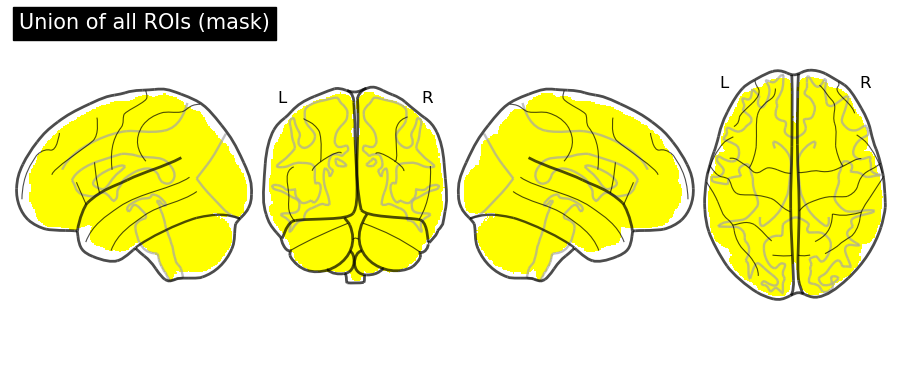

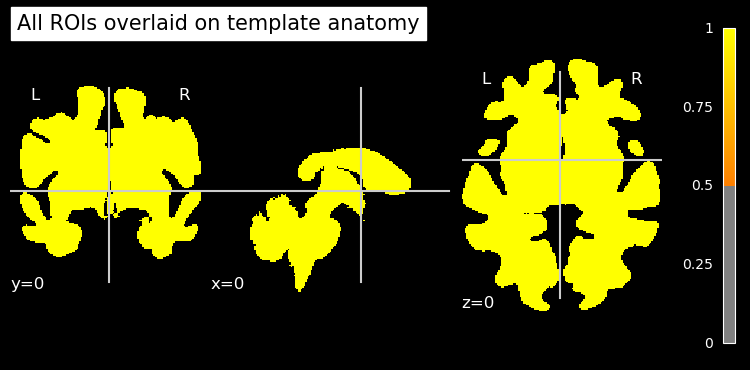

In [10]:
import numpy as np
import nibabel as nib
from nilearn import plotting

# create a binary mask of all ROIs
roi_mask = (atlas_data > 0).astype(np.uint8)
roi_img  = nib.MGHImage(roi_mask, img.affine, img.header)

# glass‐brain view of mask
plotting.plot_glass_brain(
    roi_img,
    title='Union of all ROIs (mask)',
    cmap='autumn',
    colorbar=False,
    threshold=0.5,
    display_mode='lyrz'
)

# orthogonal slice‐based view overlaid on anatomy
plotting.plot_stat_map(
    roi_img,
    bg_img=img,
    title='All ROIs overlaid on template anatomy',
    display_mode='ortho',
    cut_coords=(0, 0, 0),
    threshold=0.5,
    cmap='autumn'
)

import matplotlib.pyplot as plt
plt.show()


### Circular Correlation Comparison for Current Angle

##### Select only common channels among all epochs

In [ ]:
subjects = set(epochs_raw_all) & set(epochs_artifact_all) & set(epochs_auto_reject_all)

epochs_raw_common          = {}
epochs_artifact_common     = {}
epochs_auto_reject_common  = {}

for subj in subjects:
    ep_raw  = epochs_raw_all[subj]
    ep_art  = epochs_artifact_all[subj]
    ep_auto = epochs_auto_reject_all[subj]

    common_chs = sorted(
        set(ep_raw.ch_names) &
        set(ep_art.ch_names) &
        set(ep_auto.ch_names)
    )

    epochs_raw_common[subj]         = ep_raw.copy().pick_channels(common_chs)
    epochs_artifact_common[subj]    = ep_art.copy().pick_channels(common_chs)
    epochs_auto_reject_common[subj] = ep_auto.copy().pick_channels(common_chs)

#### Get those channels from csv

In [12]:
common_bipolar_list = []

for subj in epochs_raw_common:

    common_chs = epochs_raw_common[subj].ch_names

    df_subj = all_bipolar[
        (all_bipolar['participant'] == subj) &
        (all_bipolar['Bipolar_Label'].isin(common_chs))
    ]
    common_bipolar_list.append(df_subj)

all_bipolar_common = pd.concat(common_bipolar_list, ignore_index=True)


##### Compute significant channels thrugh ciruclar correlation for raw (manual) data

In [ ]:
signif__raw_c_df, merged_raw_c, region_counts_raw_c = channel_significance_by_window_psd(epochs_raw_common,
                                       all_bipolar_common,
                                       time_windows,
                                       freq_band=(2,12),
                                       alpha=0.05,
                                       nperm=1000,
                                       batch_size=100)

##### Compute significant channels thrugh ciruclar correlation for artifact detection data

In [ ]:
signif__artifact_c_df, merged_artifact_c, region_counts_artifact_c = channel_significance_by_window_psd(epochs_artifact_common,
                                       all_bipolar_common,
                                       time_windows,
                                       freq_band=(2,12),
                                       alpha=0.05,
                                       nperm=1000,
                                       batch_size=100)

##### Compute significant channels thrugh ciruclar correlation for autoreject data

In [ ]:
signif__autoreject_c_df, merged_autoreject_c, region_counts_autoreject_c = channel_significance_by_window_psd(epochs_auto_reject_common,
                                       all_bipolar_common,
                                       time_windows,
                                       freq_band=(2,12),
                                       alpha=0.05,
                                       nperm=1000,
                                       batch_size=100)

#### Save results

In [29]:
signif__raw_c_df.to_csv(os.path.join(results_dir, 'signif__raw_c_df.csv'), index=False)
merged_raw_c.to_csv(os.path.join(results_dir, 'merged_raw_c.csv'), index=False)
region_counts_raw_c.to_csv(os.path.join(results_dir, 'region_counts_raw_c.csv'), index=False)

signif__artifact_c_df.to_csv(os.path.join(results_dir, 'signif__artifact_c_df.csv'), index=False)
merged_artifact_c.to_csv(os.path.join(results_dir, 'merged_artifact_c.csv'), index=False)
region_counts_artifact_c.to_csv(os.path.join(results_dir, 'region_counts_artifact_c.csv'), index=False)

signif__autoreject_c_df.to_csv(os.path.join(results_dir, 'signif__autoreject_c_df.csv'), index=False)
merged_autoreject_c.to_csv(os.path.join(results_dir, 'merged_autoreject_c.csv'), index=False)
region_counts_autoreject_c.to_csv(os.path.join(results_dir, 'region_counts_autoreject_c.csv'), index=False)

#### Load results

In [13]:
# Load Raw results
signif_raw_c_df = pd.read_csv(os.path.join(results_dir, 'signif__raw_c_df.csv'))
merged_raw_c = pd.read_csv(os.path.join(results_dir, 'merged_raw_c.csv'))
region_counts_raw_c = pd.read_csv(os.path.join(results_dir, 'region_counts_raw_c.csv'))

# Load Artifact Detection results
signif_artifact_c_df = pd.read_csv(os.path.join(results_dir, 'signif__artifact_c_df.csv'))
merged_artifact_c = pd.read_csv(os.path.join(results_dir, 'merged_artifact_c.csv'))
region_counts_artifact_c = pd.read_csv(os.path.join(results_dir, 'region_counts_artifact_c.csv'))

# Load Autoreject results
signif_autoreject_c_df = pd.read_csv(os.path.join(results_dir, 'signif__autoreject_c_df.csv'))
merged_autoreject_c = pd.read_csv(os.path.join(results_dir, 'merged_autoreject_c.csv'))
region_counts_autoreject_c = pd.read_csv(os.path.join(results_dir, 'region_counts_autoreject_c.csv'))

#### Choose stricter p-value

In [15]:
merged_raw_c = merged_raw_c[merged_raw_c.pval < 0.001]
merged_artifact_c = merged_artifact_c[merged_artifact_c.pval < 0.001]
merged_autoreject_c = merged_autoreject_c[merged_autoreject_c.pval < 0.001]

#### Get channels with lower p-value for each

In [16]:
# Raw data
df_cue_raw_c   = merged_raw_c[merged_raw_c['window'] == 'cue']
df_delay_raw_c = merged_raw_c[merged_raw_c['window'] == 'delay']
df_fp_raw_c    = merged_raw_c[merged_raw_c['window'] == 'fp']
df_prefp_raw_c = merged_raw_c[merged_raw_c['window'] == 'prefp']

top_cue_raw_c    = top_regions(df_cue_raw_c,    top_n=10)
top_delay_raw_c  = top_regions(df_delay_raw_c,  top_n=10)
top_fp_raw_c     = top_regions(df_fp_raw_c,     top_n=10)
top_prefp_raw_c  = top_regions(df_prefp_raw_c,  top_n=10)

# Artifact detection data
df_cue_art_c   = merged_artifact_c[merged_artifact_c['window'] == 'cue']
df_delay_art_c = merged_artifact_c[merged_artifact_c['window'] == 'delay']
df_fp_art_c    = merged_artifact_c[merged_artifact_c['window'] == 'fp']
df_prefp_art_c = merged_artifact_c[merged_artifact_c['window'] == 'prefp']

top_cue_art_c    = top_regions(df_cue_art_c,    top_n=10)
top_delay_art_c  = top_regions(df_delay_art_c,  top_n=10)
top_fp_art_c     = top_regions(df_fp_art_c,     top_n=10)
top_prefp_art_c  = top_regions(df_prefp_art_c,  top_n=10)

# Autoreject data
df_cue_auto_c   = merged_autoreject_c[merged_autoreject_c['window'] == 'cue']
df_delay_auto_c = merged_autoreject_c[merged_autoreject_c['window'] == 'delay']
df_fp_auto_c    = merged_autoreject_c[merged_autoreject_c['window'] == 'fp']
df_prefp_auto_c = merged_autoreject_c[merged_autoreject_c['window'] == 'prefp']

top_cue_auto_c    = top_regions(df_cue_auto_c,    top_n=10)
top_delay_auto_c  = top_regions(df_delay_auto_c,  top_n=10)
top_fp_auto_c     = top_regions(df_fp_auto_c,     top_n=10)
top_prefp_auto_c  = top_regions(df_prefp_auto_c,  top_n=10)

##### Plot

In [ ]:
from nilearn import plotting, image
import matplotlib as mpl

periods = [
    (
        'Fixation Point',
        top_fp_raw_c,    top_fp_art_c,    top_fp_auto_c,
        df_fp_raw_c,     df_fp_art_c,     df_fp_auto_c
    ),
    (
        'Cue',
        top_cue_raw_c,   top_cue_art_c,   top_cue_auto_c,
        df_cue_raw_c,    df_cue_art_c,    df_cue_auto_c
    ),
    (
        'Delay',
        top_delay_raw_c, top_delay_art_c, top_delay_auto_c,
        df_delay_raw_c, df_delay_art_c,  df_delay_auto_c
    )
]

regions_all = (
    all_bipolar_common['FSLabel']
        .str.replace(r'^Mixed:', '', regex=True)
        .str.split(r'\|')
).explode()
regions_all = regions_all.loc[
    ~regions_all.str.contains('Unknown|White-Matter|WM', na=False)
].unique()
label_ids_all = [
    lid for lid, lname in label_names.items()
    if any(region == lname or region in lname for region in regions_all)
]
roi_all       = np.isin(atlas_data, label_ids_all).astype(np.float32)
roi_all_img   = image.new_img_like(img, roi_all)

all_counts = []
for _, tr, ta, to, *_ in periods:
    all_counts.extend(r['count'] for _, r in tr.iterrows())
    all_counts.extend(r['count'] for _, r in ta.iterrows())
    all_counts.extend(r['count'] for _, r in to.iterrows())
vmax = np.max(all_counts) if all_counts else 1
vmin = 1  

hist_labels = ['Manual', 'ArtDet', 'Autoreject']
col_titles  = ['Manual', 'Artifact Detection', 'Autoreject']
bar_colors  = ['#1f77b4', '#ff7f0e', '#2ca02c']

hist_heights = []
for _, *_, d1, d2, d3 in periods:
    hist_heights.extend([len(d1), len(d2), len(d3)])
hist_max = max(hist_heights)

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap = mpl.cm.get_cmap('viridis_r')  # '_r' suffix inverts the colormap

fig = plt.figure(figsize=(44, 24))
gs  = fig.add_gridspec(
    4, 4,
    width_ratios =[35, 35, 35, 10],
    height_ratios=[15, 35, 35, 35],
    wspace=0.6, hspace=0.8
)

ax_all = fig.add_subplot(gs[0, 0:3])
plotting.plot_glass_brain(
    roi_all_img,
    axes        = ax_all,
    display_mode= 'lyrz',
    threshold   = 0.1,
    cmap        = cmap,
    colorbar    = False,
    vmin        = vmin,
    vmax        = vmax
)
ax_all.set_title('All Available Regions', fontsize=24, weight='bold')
ax_all.axis('off')

for col, title in enumerate(col_titles):
    ax_ref = fig.add_subplot(gs[0, col])
    pos    = ax_ref.get_position()
    fig.text(
        pos.x0 + pos.width / 2,
        pos.y0 - 0.02,
        title,
        ha='center', va='top',
        fontsize=24, weight='bold'
    )
    ax_ref.remove()

# 6. now plot each period × method in rows 2–4 (indices 1–3)
for row, (label, top_raw, top_art, top_auto, df_raw, df_art, df_auto) in enumerate(periods, start=1):

    # glass‐brain panels
    for col, top_df in enumerate([top_raw, top_art, top_auto]):
        roi_vol = np.zeros_like(atlas_data, dtype=np.float32)
        for _, rec in top_df.iterrows():
            name, count = rec['Count'], rec['count']
            for lid, lname in label_names.items():
                if name in lname:
                    roi_vol[atlas_data == lid] = count

        roi_img = image.new_img_like(img, roi_vol)
        ax      = fig.add_subplot(gs[row+0, col])
        plotting.plot_glass_brain(
            roi_img,
            axes        = ax,
            display_mode= 'lyrz',
            threshold   = 0.1,
            cmap        = cmap,
            colorbar    = False,
            vmin        = vmin,
            vmax        = vmax
)
        ax.axis('off')

        # per‐panel colorbar
        pos = ax.get_position()
        cax = fig.add_axes([pos.x1 + 0.005, pos.y0, 0.005, pos.height])
        sm  = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cb  = fig.colorbar(sm, cax=cax, orientation='vertical')
        cb.set_label('ROI Count')

    # side histogram of total ROIs
    axh    = fig.add_subplot(gs[row, 3])
    counts = [len(df_raw), len(df_art), len(df_auto)]
    axh.bar(range(len(hist_labels)), counts, color=bar_colors)
    axh.set_xticks(range(len(hist_labels)))
    axh.set_xticklabels(hist_labels, rotation=45, ha='right', fontsize=16)
    axh.set_ylim(0, hist_max + 1)
    axh.set_title("Total ROIs", pad=10)
    axh.set_ylabel("n ROIs")
    axh.spines['top'].set_visible(False)
    axh.spines['right'].set_visible(False)

    # period label at left
    ax_ref = fig.add_subplot(gs[row, 0])
    pos    = ax_ref.get_position()
    fig.text(
        0.02,
        pos.y0 + pos.height / 2,
        label, va='center',
        ha='left',
        fontsize=24, weight='bold'
    )
    ax_ref.remove()

plt.show()

# Previous angle

In [39]:
def channel_significance_by_window_psd_preT(epochs_dict,
                                       electrode_df,
                                       time_windows,
                                       freq_band=(2,12),
                                       alpha=0.05,
                                       nperm=200,
                                       batch_size=100):

    records = []
    for subj, ep in epochs_dict.items():
        for label, (tmin, tmax) in time_windows.items():
            ep_win = ep.copy().crop(tmin, tmax)

            angles = ep_win.metadata['preT'].values
            valid_trials = ~np.isnan(angles)
            angles_valid = np.deg2rad(angles[valid_trials])
            ep_win_valid = ep_win[valid_trials]  
            
            if len(angles_valid) == 0:
                continue  
                
            R_true, R_null = compute_null_psd(
                ep_win_valid, angles_valid, 
                freq_band=freq_band,
                get_freq_spec=get_freq_spec,
                norm_freq=norm_freq,
                nperm=nperm,
                batch_size=batch_size
            )

            pvals = np.mean(R_true[np.newaxis, :] < R_null, axis=0)

            for idx, ch in enumerate(ep_win_valid.ch_names): 
                if pvals[idx] < alpha:
                    records.append({
                        'participant': subj,
                        'channel':     ch,
                        'window':      label,
                        'pval':        float(pvals[idx])
                    })

    signif_df = pd.DataFrame.from_records(records)

    merged = signif_df.merge(
        electrode_df[['participant', 'Bipolar_Label', 'FSLabel']],
        left_on=['participant', 'channel'],
        right_on=['participant', 'Bipolar_Label'],
        how='left'
    )
    merged['region'] = (
        merged['FSLabel']
              .str.replace(r'^Mixed:', '', regex=True)
              .str.split(r'\|')
    ).explode('region')

    bad = merged['region'].str.contains('Unknown|White-Matter|WM', na=False)
    merged = merged.loc[~bad, ['participant', 'channel', 'window', 'pval', 'region']]

    region_counts = (
        merged.groupby('region')
              .size()
              .reset_index(name='count')
              .sort_values('count', ascending=False)
              .reset_index(drop=True)
    )

    return signif_df, merged, region_counts

In [ ]:
pre_signif__raw_c_df, pre_merged_raw_c, pre_region_counts_raw_c = channel_significance_by_window_psd_preT(epochs_raw_common,
                                       all_bipolar_common,
                                       time_windows,
                                       freq_band=(2,12),
                                       alpha=0.05,
                                       nperm=1000,
                                       batch_size=100)

In [ ]:
pre_signif__artifact_c_df, pre_merged_artifact_c, pre_region_counts_artifact_c = channel_significance_by_window_psd_preT(epochs_artifact_common,
                                       all_bipolar_common,
                                       time_windows,
                                       freq_band=(2,12),
                                       alpha=0.05,
                                       nperm=1000,
                                       batch_size=100)

In [ ]:
pre_signif__autoreject_c_df, pre_merged_autoreject_c, pre_region_counts_autoreject_c = channel_significance_by_window_psd_preT(epochs_auto_reject_common,
                                       all_bipolar_common,
                                       time_windows,
                                       freq_band=(2,12),
                                       alpha=0.05,
                                       nperm=1000,
                                       batch_size=100)

In [78]:
pre_signif__raw_c_df.to_csv(os.path.join(results_dir, 'pre_signif__raw_c_df.csv'), index=False)
pre_merged_raw_c.to_csv(os.path.join(results_dir, 'pre_merged_raw_c.csv'), index=False)
pre_region_counts_raw_c.to_csv(os.path.join(results_dir, 'pre_region_counts_raw_c.csv'), index=False)

pre_signif__artifact_c_df.to_csv(os.path.join(results_dir, 'pre_signif__artifact_c_df.csv'), index=False)
pre_merged_artifact_c.to_csv(os.path.join(results_dir, 'pre_merged_artifact_c.csv'), index=False)
pre_region_counts_artifact_c.to_csv(os.path.join(results_dir, 'pre_region_counts_artifact_c.csv'), index=False)

pre_signif__autoreject_c_df.to_csv(os.path.join(results_dir, 'pre_signif__autoreject_c_df.csv'), index=False)
pre_merged_autoreject_c.to_csv(os.path.join(results_dir, 'pre_merged_autoreject_c.csv'), index=False)
pre_region_counts_autoreject_c.to_csv(os.path.join(results_dir, 'pre_region_counts_autoreject_c.csv'), index=False)

In [40]:
pre_signif__raw_c_df = pd.read_csv(os.path.join(results_dir, 'pre_signif__raw_c_df.csv'))
pre_merged_raw_c = pd.read_csv(os.path.join(results_dir, 'pre_merged_raw_c.csv'))
pre_region_counts_raw_c = pd.read_csv(os.path.join(results_dir, 'pre_region_counts_raw_c.csv'))

pre_signif__artifact_c_df = pd.read_csv(os.path.join(results_dir, 'pre_signif__artifact_c_df.csv'))
pre_merged_artifact_c = pd.read_csv(os.path.join(results_dir, 'pre_merged_artifact_c.csv'))
pre_region_counts_artifact_c = pd.read_csv(os.path.join(results_dir, 'pre_region_counts_artifact_c.csv'))

pre_signif__autoreject_c_df = pd.read_csv(os.path.join(results_dir, 'pre_signif__autoreject_c_df.csv'))
pre_merged_autoreject_c = pd.read_csv(os.path.join(results_dir, 'pre_merged_autoreject_c.csv'))
pre_region_counts_autoreject_c = pd.read_csv(os.path.join(results_dir, 'pre_region_counts_autoreject_c.csv'))

In [41]:
pre_merged_raw_c = pre_merged_raw_c[pre_merged_raw_c.pval < 0.001]
pre_merged_artifact_c = pre_merged_artifact_c[pre_merged_artifact_c.pval < 0.001]
pre_merged_autoreject_c = pre_merged_autoreject_c[pre_merged_autoreject_c.pval < 0.001]

In [42]:
# Raw data
df_cue_raw_c_pre   = pre_merged_raw_c[pre_merged_raw_c['window'] == 'cue']
df_delay_raw_c_pre = pre_merged_raw_c[pre_merged_raw_c['window'] == 'delay']
df_fp_raw_c_pre    = pre_merged_raw_c[pre_merged_raw_c['window'] == 'fp']
df_prefp_raw_c_pre = pre_merged_raw_c[pre_merged_raw_c['window'] == 'prefp']

top_cue_raw_c_pre    = top_regions(df_cue_raw_c_pre,    top_n=10)
top_delay_raw_c_pre  = top_regions(df_delay_raw_c_pre,  top_n=10)
top_fp_raw_c_pre     = top_regions(df_fp_raw_c_pre,     top_n=10)
top_prefp_raw_c_pre  = top_regions(df_prefp_raw_c_pre,  top_n=10)

# Artifact detection data
df_cue_art_c_pre   = pre_merged_artifact_c[pre_merged_artifact_c['window'] == 'cue']
df_delay_art_c_pre = pre_merged_artifact_c[pre_merged_artifact_c['window'] == 'delay']
df_fp_art_c_pre    = pre_merged_artifact_c[pre_merged_artifact_c['window'] == 'fp']
df_prefp_art_c_pre = pre_merged_artifact_c[pre_merged_artifact_c['window'] == 'prefp']

top_cue_art_c_pre    = top_regions(df_cue_art_c_pre,    top_n=10)
top_delay_art_c_pre  = top_regions(df_delay_art_c_pre,  top_n=10)
top_fp_art_c_pre     = top_regions(df_fp_art_c_pre,     top_n=10)
top_prefp_art_c_pre  = top_regions(df_prefp_art_c_pre,  top_n=10)

# Autoreject data
df_cue_auto_c_pre   = pre_merged_autoreject_c[pre_merged_autoreject_c['window'] == 'cue']
df_delay_auto_c_pre = pre_merged_autoreject_c[pre_merged_autoreject_c['window'] == 'delay']
df_fp_auto_c_pre    = pre_merged_autoreject_c[pre_merged_autoreject_c['window'] == 'fp']
df_prefp_auto_c_pre = pre_merged_autoreject_c[pre_merged_autoreject_c['window'] == 'prefp']

top_cue_auto_c_pre    = top_regions(df_cue_auto_c_pre,    top_n=10)
top_delay_auto_c_pre  = top_regions(df_delay_auto_c_pre,  top_n=10)
top_fp_auto_c_pre     = top_regions(df_fp_auto_c_pre,     top_n=10)
top_prefp_auto_c_pre  = top_regions(df_prefp_auto_c_pre,  top_n=10)

Data shape debugging:
Pre Fixation Point:
  top shapes: 9, 10, 2
  df shapes:  12, 13, 2
Fixation Point:
  top shapes: 2, 3, 0
  df shapes:  2, 3, 0
Cue:
  top shapes: 0, 0, 1
  df shapes:  0, 0, 1
Delay:
  top shapes: 1, 1, 1
  df shapes:  1, 1, 1


/home/intracranial/fsl/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:313: UserWarning: empty mask
  ims = self._map_show(img, type="imshow", threshold=threshold, **kwargs)
/home/intracranial/fsl/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:313: UserWarning: empty mask
  ims = self._map_show(img, type="imshow", threshold=threshold, **kwargs)


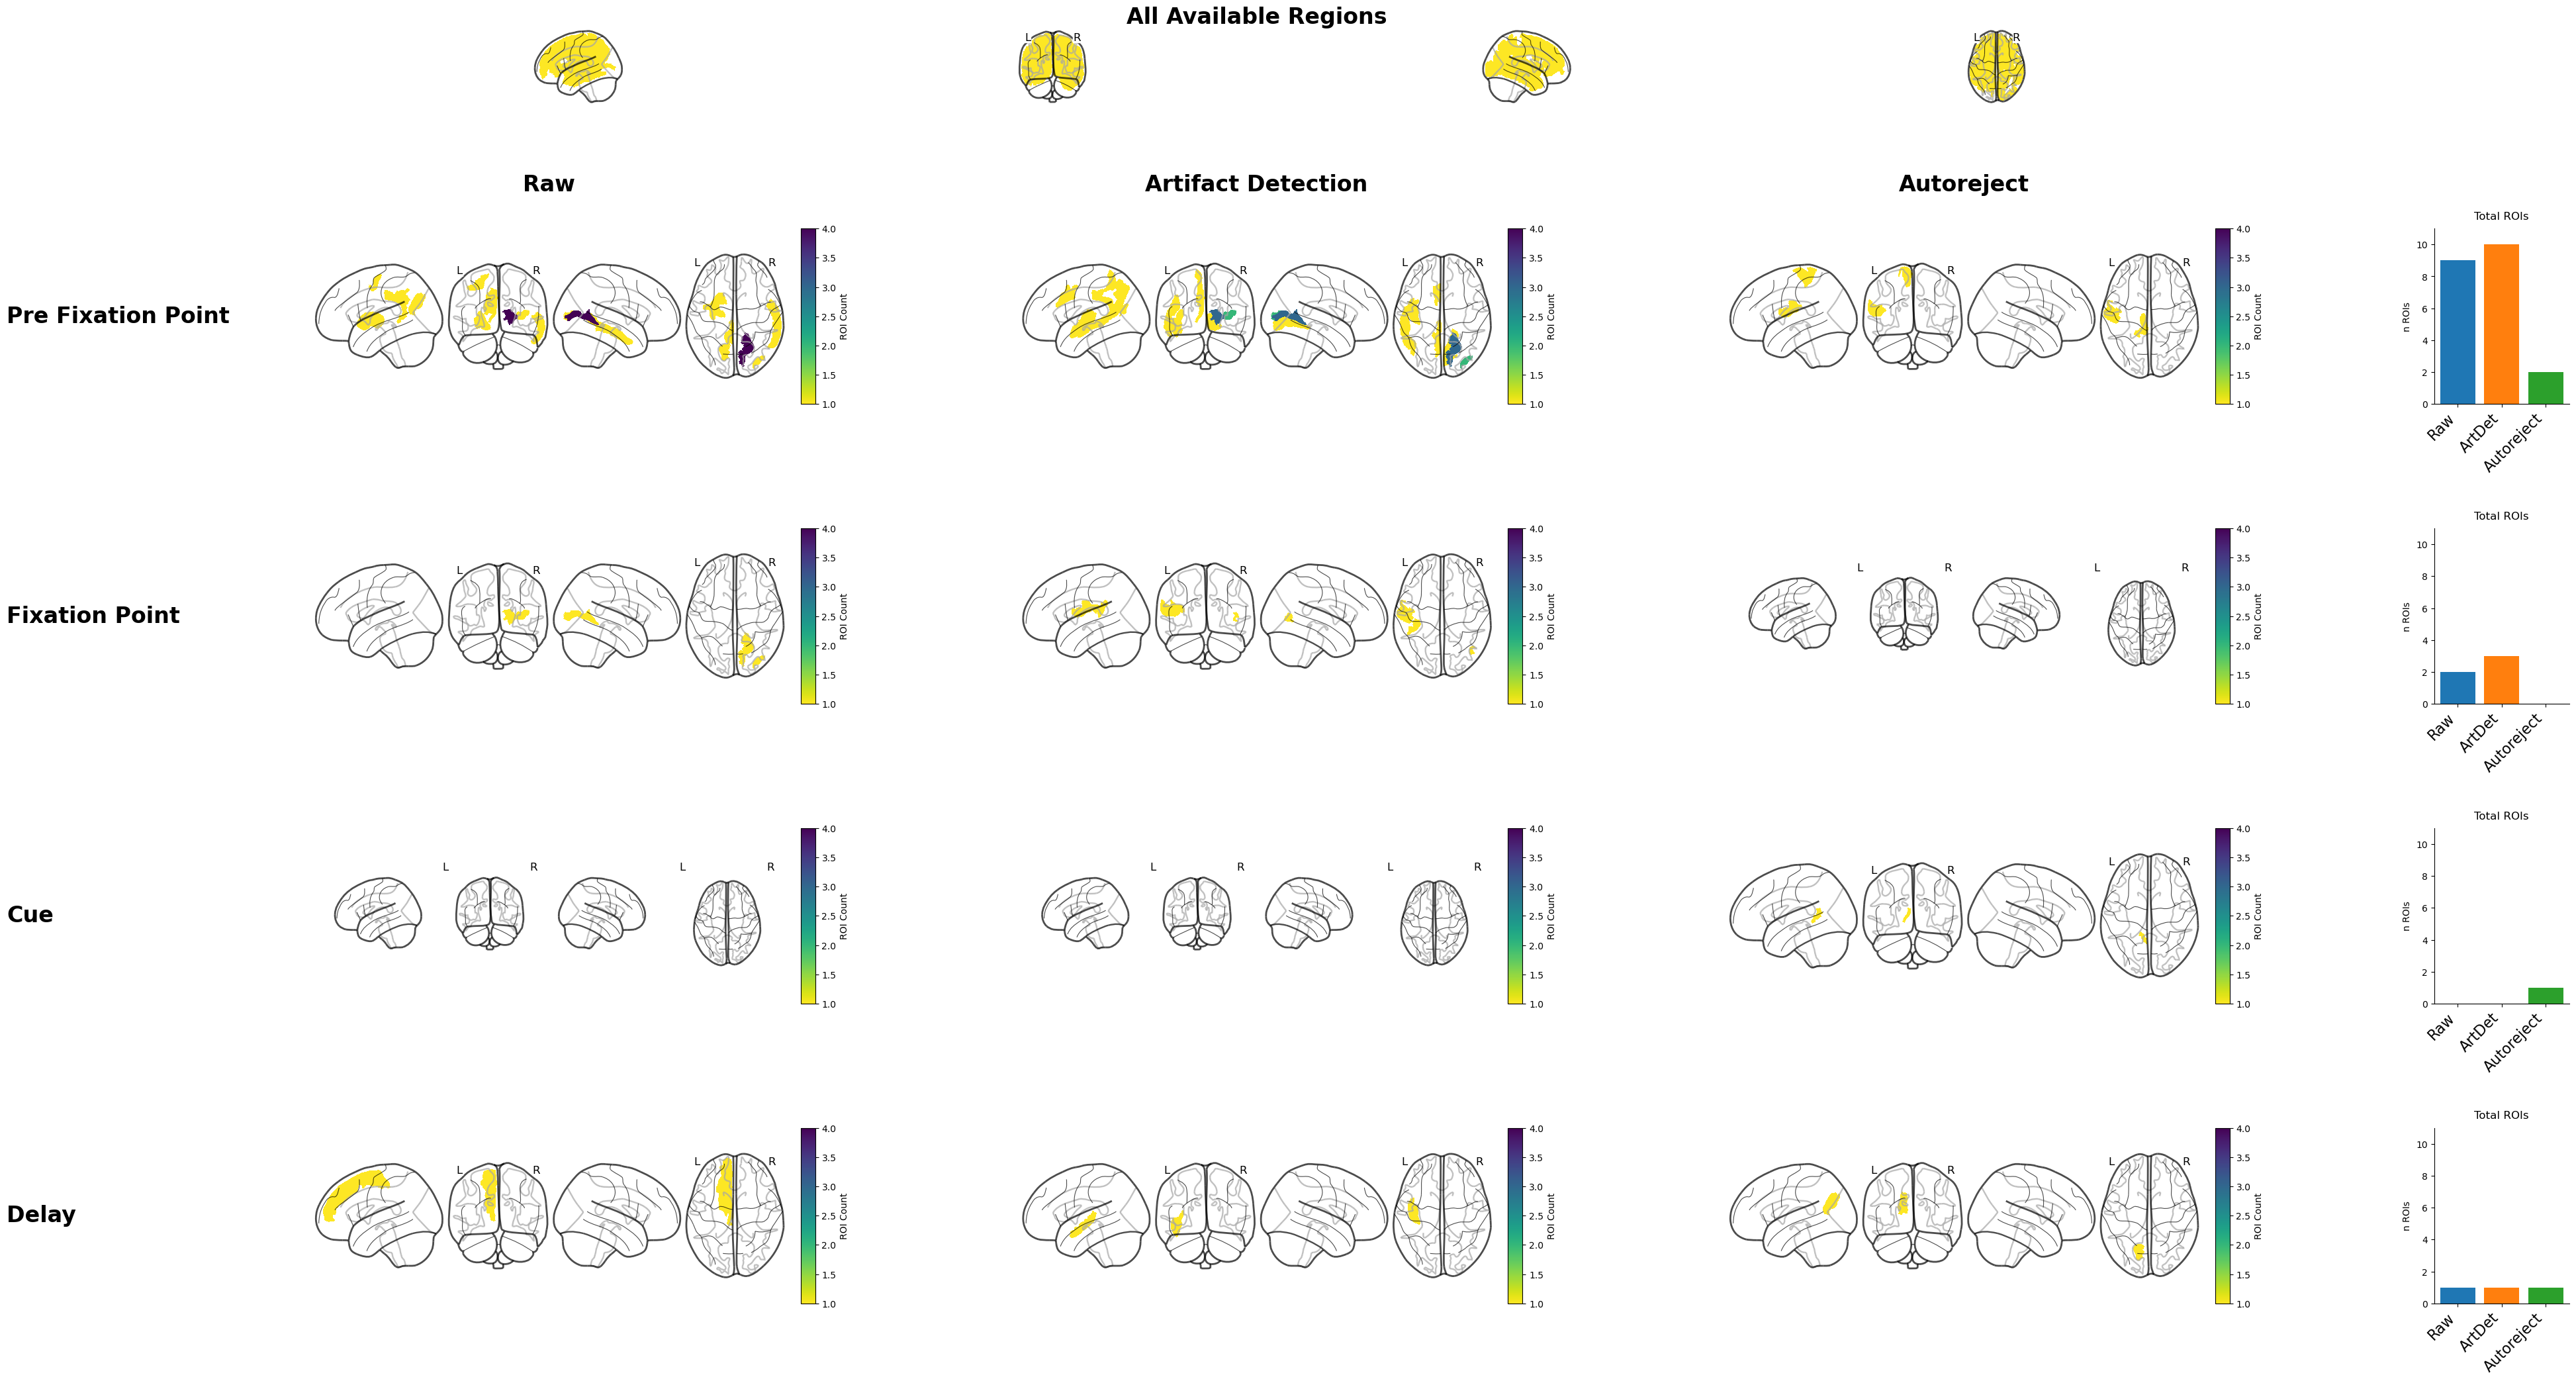

In [49]:
from nilearn import plotting, image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

periods = [
    (
        'Pre Fixation Point',
        top_prefp_raw_c_pre,   top_prefp_art_c_pre,   top_prefp_auto_c_pre,
        df_prefp_raw_c_pre,    df_prefp_art_c_pre,    df_prefp_auto_c_pre
    ),
    (
        'Fixation Point',
        top_fp_raw_c_pre,      top_fp_art_c_pre,      top_fp_auto_c_pre,
        df_fp_raw_c_pre,       df_fp_art_c_pre,       df_fp_auto_c_pre
    ),
    (
        'Cue',
        top_cue_raw_c_pre,     top_cue_art_c_pre,     top_cue_auto_c_pre,
        df_cue_raw_c_pre,      df_cue_art_c_pre,      df_cue_auto_c_pre
    ),
    (
        'Delay',
        top_delay_raw_c_pre,   top_delay_art_c_pre,   top_delay_auto_c_pre,
        df_delay_raw_c_pre,    df_delay_art_c_pre,    df_delay_auto_c_pre
    )
]

hist_labels = ['Raw', 'ArtDet', 'Autoreject']
col_titles  = ['Raw', 'Artifact Detection', 'Autoreject']
bar_colors  = ['#1f77b4', '#ff7f0e', '#2ca02c']

regions_all = (
    all_bipolar_common['FSLabel']
       .str.replace(r'^Mixed:', '', regex=True)
       .str.split(r'\|')
).explode()
regions_all = regions_all.loc[
    ~regions_all.str.contains('Unknown|White-Matter|WM', na=False)
].unique()
label_ids_all = [
    lid for lid, lname in label_names.items()
    if any(region == lname or region in lname for region in regions_all)
]
roi_all     = np.isin(atlas_data, label_ids_all).astype(np.float32)
roi_all_img = image.new_img_like(img, roi_all)

# Debug: Print data shapes to identify the discrepancy
print("Data shape debugging:")
for i, (label, top_raw, top_art, top_auto, df_raw, df_art, df_auto) in enumerate(periods):
    print(f"{label}:")
    print(f"  top shapes: {len(top_raw)}, {len(top_art)}, {len(top_auto)}")
    print(f"  df shapes:  {len(df_raw)}, {len(df_art)}, {len(df_auto)}")

all_counts = []
for _, tr, ta, to, *_ in periods:
    all_counts.extend(r['count'] for _, r in tr.iterrows())
    all_counts.extend(r['count'] for _, r in ta.iterrows())
    all_counts.extend(r['count'] for _, r in to.iterrows())
vmax = np.max(all_counts) if all_counts else 1
vmin = 1

# Use the same dataframes for both visualization and histogram counting
hist_heights = []
for _, tr, ta, to, *_ in periods:  # Use top_* dataframes for consistency
    hist_heights.extend([len(tr), len(ta), len(to)])
hist_max = max(hist_heights) if hist_heights else 1

norm     = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap_rev = mpl.colormaps.get_cmap('viridis_r')  # Updated matplotlib syntax

fig = plt.figure(figsize=(44, 25))
gs  = fig.add_gridspec(
    5, 4,
    width_ratios =[35, 35, 35, 10],
    height_ratios=[15, 35, 35, 35, 35],
    wspace=0.6,
    hspace=0.8
)

ax_all = fig.add_subplot(gs[0, 0:3])
plotting.plot_glass_brain(
    roi_all_img,
    axes        = ax_all,
    display_mode= 'lyrz',
    threshold   = 0.1,
    cmap        = cmap_rev,
    colorbar    = False,
    vmin        = vmin,
    vmax        = vmax
)
ax_all.set_title('All Available Regions', fontsize=24, weight='bold')
ax_all.axis('off')

for col, title in enumerate(col_titles):
    ax_ref = fig.add_subplot(gs[1, col])
    pos    = ax_ref.get_position()
    fig.text(
        pos.x0 + pos.width / 2,
        pos.y1 + 0.02,
        title,
        ha='center', va='bottom',
        fontsize=24, weight='bold'
    )
    ax_ref.remove()

for row, (label, top_raw, top_art, top_auto, df_raw, df_art, df_auto) in enumerate(periods, start=1):

    for col, top_df in enumerate([top_raw, top_art, top_auto]):
        roi_vol = np.zeros_like(atlas_data, dtype=np.float32)
        for _, rec in top_df.iterrows():
            name, count = rec['Count'], rec['count']
            for lid, lname in label_names.items():
                if name in lname:
                    roi_vol[atlas_data == lid] = count

        roi_img = image.new_img_like(img, roi_vol)
        ax      = fig.add_subplot(gs[row, col])
        plotting.plot_glass_brain(
            roi_img,
            axes        = ax,
            display_mode= 'lyrz',
            threshold   = 0.1,
            cmap        = cmap_rev,
            colorbar    = False,
            vmin        = vmin,
            vmax        = vmax
        )
        ax.axis('off')

        pos = ax.get_position()
        cax = fig.add_axes([pos.x1 + 0.005, pos.y0, 0.005, pos.height])
        sm  = mpl.cm.ScalarMappable(cmap=cmap_rev, norm=norm)
        sm.set_array([])
        cb  = fig.colorbar(sm, cax=cax, orientation='vertical')
        cb.set_label('ROI Count')

    # Use top_* dataframes for histogram counting to match the brain visualization
    axh    = fig.add_subplot(gs[row, 3])
    counts = [len(top_raw), len(top_art), len(top_auto)]  # Changed from df_* to top_*
    axh.bar(range(len(hist_labels)), counts, color=bar_colors)
    axh.set_xticks(range(len(hist_labels)))
    axh.set_xticklabels(hist_labels, rotation=45, ha='right', fontsize=16)
    axh.set_ylim(0, hist_max + 1)  # Start histogram y-axis at 0, not vmin
    axh.set_title("Total ROIs", pad=10)
    axh.set_ylabel("n ROIs")
    axh.spines['top'].set_visible(False)
    axh.spines['right'].set_visible(False)

    # Row label at left
    ax_ref = fig.add_subplot(gs[row, 0])
    pos    = ax_ref.get_position()
    fig.text(
        0.02,
        pos.y0 + pos.height / 2,
        label,
        va='center', ha='left',
        fontsize=24, weight='bold'
    )
    ax_ref.remove()

plt.show()

In [50]:
def count_signif_rois(merged_df):
    # Group by participant and window, and count unique channels
    counts = (merged_df.groupby(['participant', 'window'])['channel']
                     .nunique()
                     .reset_index()
                     .rename(columns={'channel': 'n_signif_rois'}))
    return counts

raw_counts_pre = count_signif_rois(pre_merged_raw_c)
artifact_counts_pre = count_signif_rois(pre_merged_artifact_c)
autoreject_counts_pre = count_signif_rois(pre_merged_autoreject_c)

# Extra measures

          Raw  Artifact  Auto-Reject
S01  0.219512  0.292683     0.000000
S03  0.051546  0.041237     0.010309
S04  0.028169  0.028169     0.014085
s06  0.000000  0.000000     0.000000
s08  0.057143  0.057143     0.000000


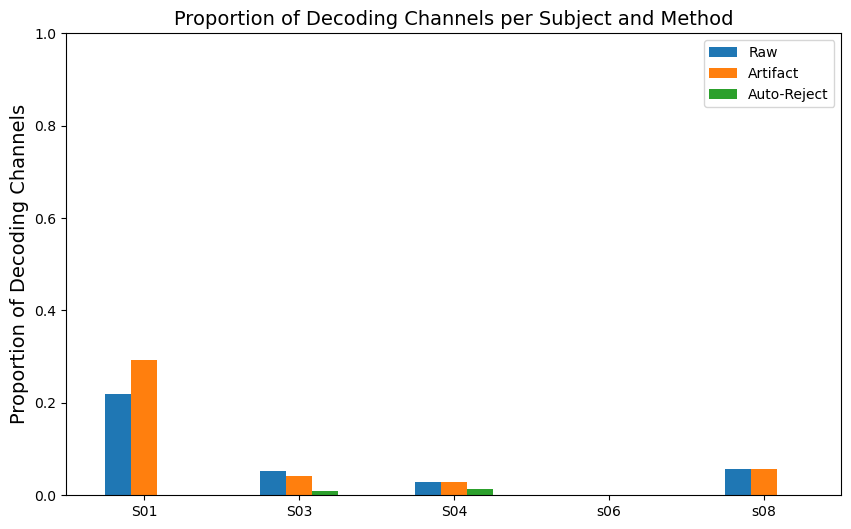

In [52]:
subjects = sorted(epochs_raw_common.keys())

methods = {
    'Raw': merged_raw_c,
    'Artifact': merged_artifact_c,
    'Auto-Reject': merged_autoreject_c
}

proportions = {}

for subj in subjects:

    total_ch = len(epochs_raw_common[subj].ch_names)
    proportions[subj] = {}
    for method, df in methods.items():

        df_sub = df[df['participant'] == subj]

        sig_channels = df_sub['channel'].unique()
        proportions[subj][method] = len(sig_channels) / total_ch if total_ch > 0 else np.nan

prop_df = pd.DataFrame(proportions).T  
print(prop_df)

prop_df.plot(kind='bar', figsize=(10,6))
plt.xticks(rotation=0)
plt.ylabel('Proportion of Decoding Channels', fontsize=14)
plt.title('Proportion of Decoding Channels per Subject and Method', fontsize=14)
plt.ylim(0, 1)
plt.legend()
plt.show()

In [ ]:
subjects = sorted(epochs_raw_all.keys())
for subj in subjects:
    count_raw  = len(epochs_raw_all[subj])
    count_art  = len(epochs_artifact_all[subj])
    count_auto = len(epochs_auto_reject_all[subj])
    print(f"Subject {subj}: Raw = {count_raw}, Artifact = {count_art}, Auto-Reject = {count_auto}")

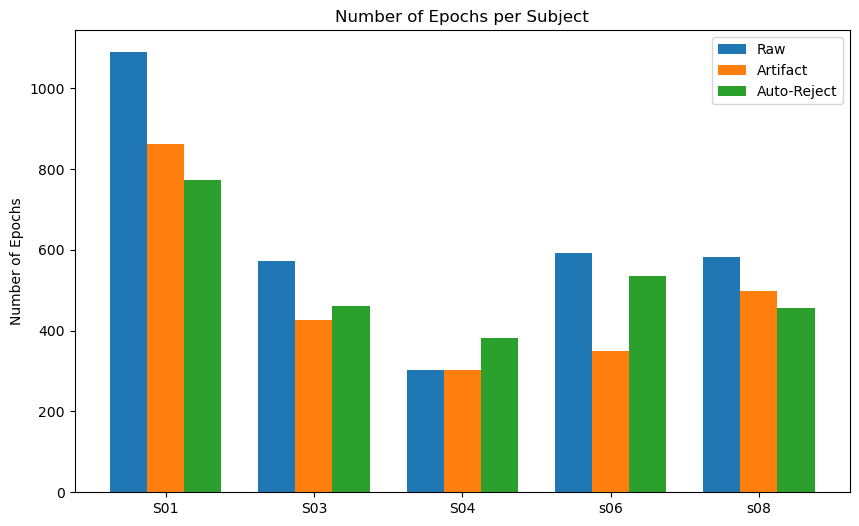

In [54]:
import numpy as np
import matplotlib.pyplot as plt

subjects = sorted(epochs_raw_all.keys())
counts_raw = [len(epochs_raw_all[subj]) for subj in subjects]
counts_art = [len(epochs_artifact_all[subj]) for subj in subjects]
counts_auto = [len(epochs_auto_reject_all[subj]) for subj in subjects]

x = np.arange(len(subjects))
width = 0.25

plt.figure(figsize=(10,6))
plt.bar(x - width, counts_raw, width, label='Raw')
plt.bar(x, counts_art, width, label='Artifact')
plt.bar(x + width, counts_auto, width, label='Auto-Reject')

plt.xticks(x, subjects)
plt.ylabel('Number of Epochs')
plt.title('Number of Epochs per Subject')
plt.legend()
plt.show()

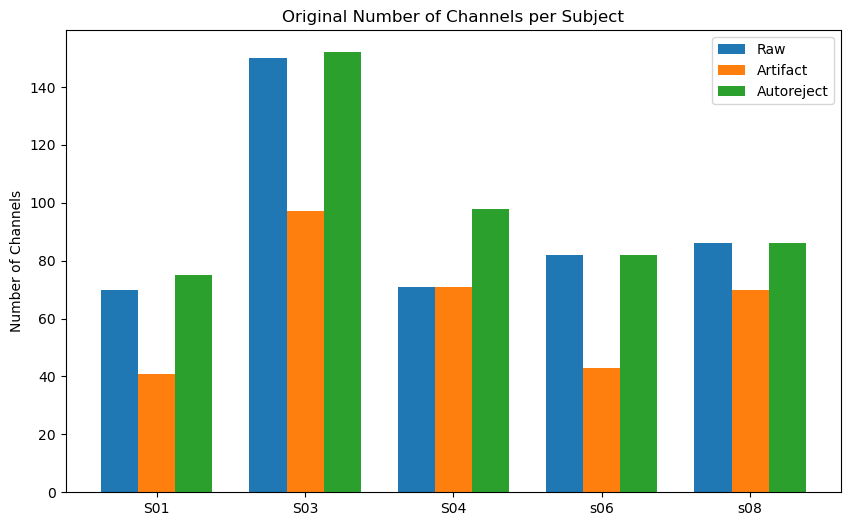

In [55]:
def count_original_channels(epoch_dict):
    counts = {}
    for subj, ep in epoch_dict.items():
        counts[subj] = len(ep.ch_names)
    return counts

raw_channel_counts       = count_original_channels(epochs_raw_all)
artifact_channel_counts  = count_original_channels(epochs_artifact_all)
autoreject_channel_counts = count_original_channels(epochs_auto_reject_all)

subjects = sorted(epochs_raw_all.keys())
x = range(len(subjects))
width = 0.25

raw_counts  = [raw_channel_counts[subj] for subj in subjects]
artifact_counts = [artifact_channel_counts[subj] for subj in subjects]
autoreject_counts = [autoreject_channel_counts[subj] for subj in subjects]

plt.figure(figsize=(10,6))
plt.bar([i - width for i in x], raw_counts, width, label='Raw')
plt.bar(x, artifact_counts, width, label='Artifact')
plt.bar([i + width for i in x], autoreject_counts, width, label='Autoreject')

plt.xticks(x, subjects)
plt.ylabel('Number of Channels')
plt.title('Original Number of Channels per Subject')
plt.legend()
plt.show()

# Multivariate SVM

In [56]:
def decode_with_psd_permutation(epochs, angles_deg, freq_band=(70,150),
                                nfold=5, nperm=200, random_state=42):

    X_raw = epochs.get_data()  # n_trials, n_ch, n_time
    psd_mt, freqs, _ = get_freq_spec(X_raw, epochs.info['sfreq'])
    X_rel = norm_freq(psd_mt, freqs, fband=freq_band)  # (n_trials, n_ch)

    angles_rad = np.deg2rad(angles_deg)
    
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=nfold, shuffle=True, random_state=random_state)
    
    def one_decoding(X, y_rad):
        errs = []
        for train_ix, test_ix in kf.split(X):
            scaler = StandardScaler().fit(X[train_ix]) # Computes mean & std of each channel on the training set.
            X_train = scaler.transform(X[train_ix]) # Ensures each channel’s feature has zero mean & unit variance—so no single channel dominates.
            X_test  = scaler.transform(X[test_ix])
            
            clf = make_pipeline(AngularRegression(clf=LinearSVR())) # A linear support‐vector regression. Wraps regressor to handle circular targets correctly
            clf.fit(X_train, y_rad[train_ix]) # Learns a weight per channel
            preds_rad = clf.predict(X_test)
            
            err_rad = np.angle(np.exp(1j*(preds_rad - y_rad[test_ix])))

            errs.append(np.mean(np.abs(np.rad2deg(err_rad))))
        return np.mean(errs)
    

    real_error = one_decoding(X_rel, angles_rad)
    

    perm_errors = np.zeros(nperm)
    rng = np.random.RandomState(random_state)
    for i in range(nperm):
        y_perm = rng.permutation(angles_rad)
        perm_errors[i] = one_decoding(X_rel, y_perm)

    p_value = np.mean(perm_errors <= real_error)
    
    return real_error, perm_errors, p_value


In [ ]:
time_windows = {
    'prefp': (-0.6, -0.1),
    'fp':    (0.0,  0.5),
    'cue':   (1.1,  1.6),
    'delay': (1.6,  2.1)
}

results_art_2_12 = {}

for subj, ep in epochs_artifact_all.items():
    results_art_2_12[subj] = {}
    for window_name, (tmin, tmax) in time_windows.items():

        ep_win = ep.copy().crop(tmin, tmax)
        
        if window_name in ('prefp', 'fp'):
            angles_deg = ep_win.metadata['preT'].values
        else:
            angles_deg = ep_win.metadata['T_Angle'].values

        valid = ~np.isnan(angles_deg)
        ep_sel = ep_win[valid]
        angles_sel = angles_deg[valid]

        real_err, null_errs, pval = decode_with_psd_permutation(
            ep_sel,
            angles_sel,
            freq_band=(2, 12),
            nfold=5,
            nperm=200,
            random_state=42
        )

        results_art_2_12[subj][window_name] = {
            'real_error':   real_err,
            'null_errors':  null_errs,
            'p_value':      pval
        }

        plt.figure(figsize=(5, 3))
        plt.hist(null_errs, bins=25, alpha=0.7, edgecolor='k')
        plt.axvline(real_err, color='r', lw=2,
                    label=f"actual = {real_err:.2f}°")
        plt.title(f"{subj} – {window_name} Decoding Null Distribution")
        plt.xlabel("Mean angular error (°)")
        plt.legend()
        plt.tight_layout()
        plt.show()

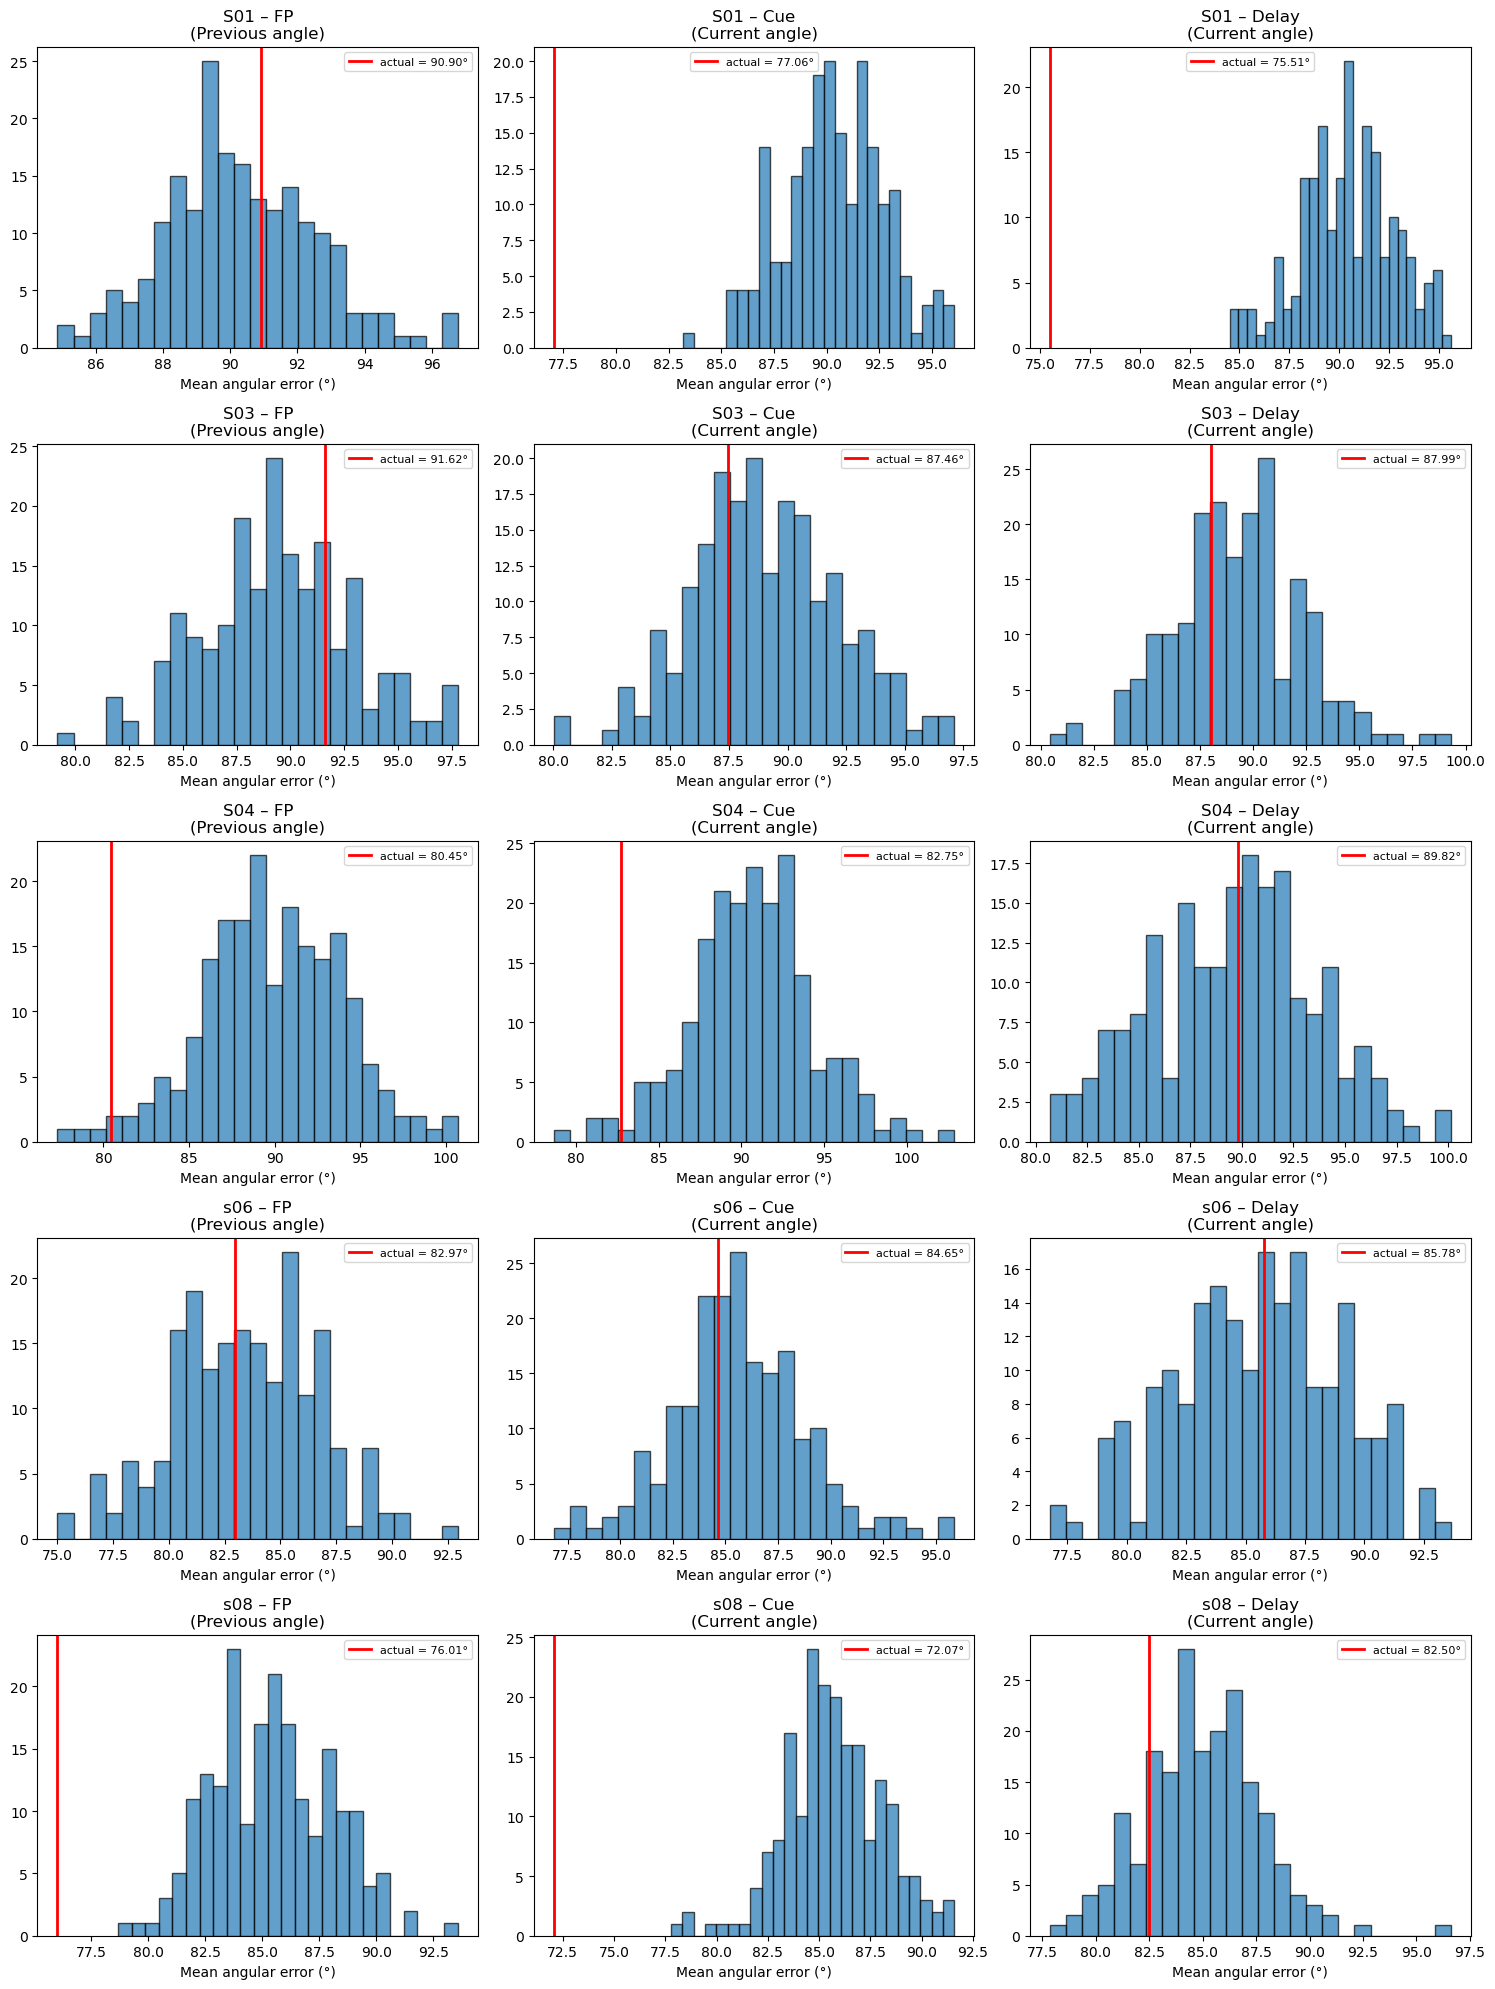

In [ ]:
periods = ['FP', 'Cue', 'Delay']

subjects = sorted(results_art_2_12.keys())

n_rows = len(subjects)
n_cols = len(periods)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows), squeeze=False)

for i, subj in enumerate(subjects):
    for j, period in enumerate(periods):
        ax = axs[i, j]

        key = period.lower()  
        res = results_art_2_12[subj].get(key, None)
        if res is not None:
            null_errs = res['null_errors']
            real_err = res['real_error']
            ax.hist(null_errs, bins=25, alpha=0.7, edgecolor='k')
            ax.axvline(real_err, color='r', lw=2, label=f"actual = {real_err:.2f}°")

            method = "Previous angle" if period == 'FP' else "Current angle"
            ax.set_title(f"{subj} – {period}\n({method})")
            ax.set_xlabel("Mean angular error (°)")
            ax.legend(fontsize=8)
        else:
            ax.text(0.5, 0.5, "No data", ha='center', va='center')
            ax.set_title(f"{subj} – {period}")
plt.tight_layout()
plt.show()

In [62]:
output_path = os.path.join(results_dir, "results_art_2_12.pkl")
with open(output_path, "wb") as f:
    pickle.dump(results_art_2_12, f)

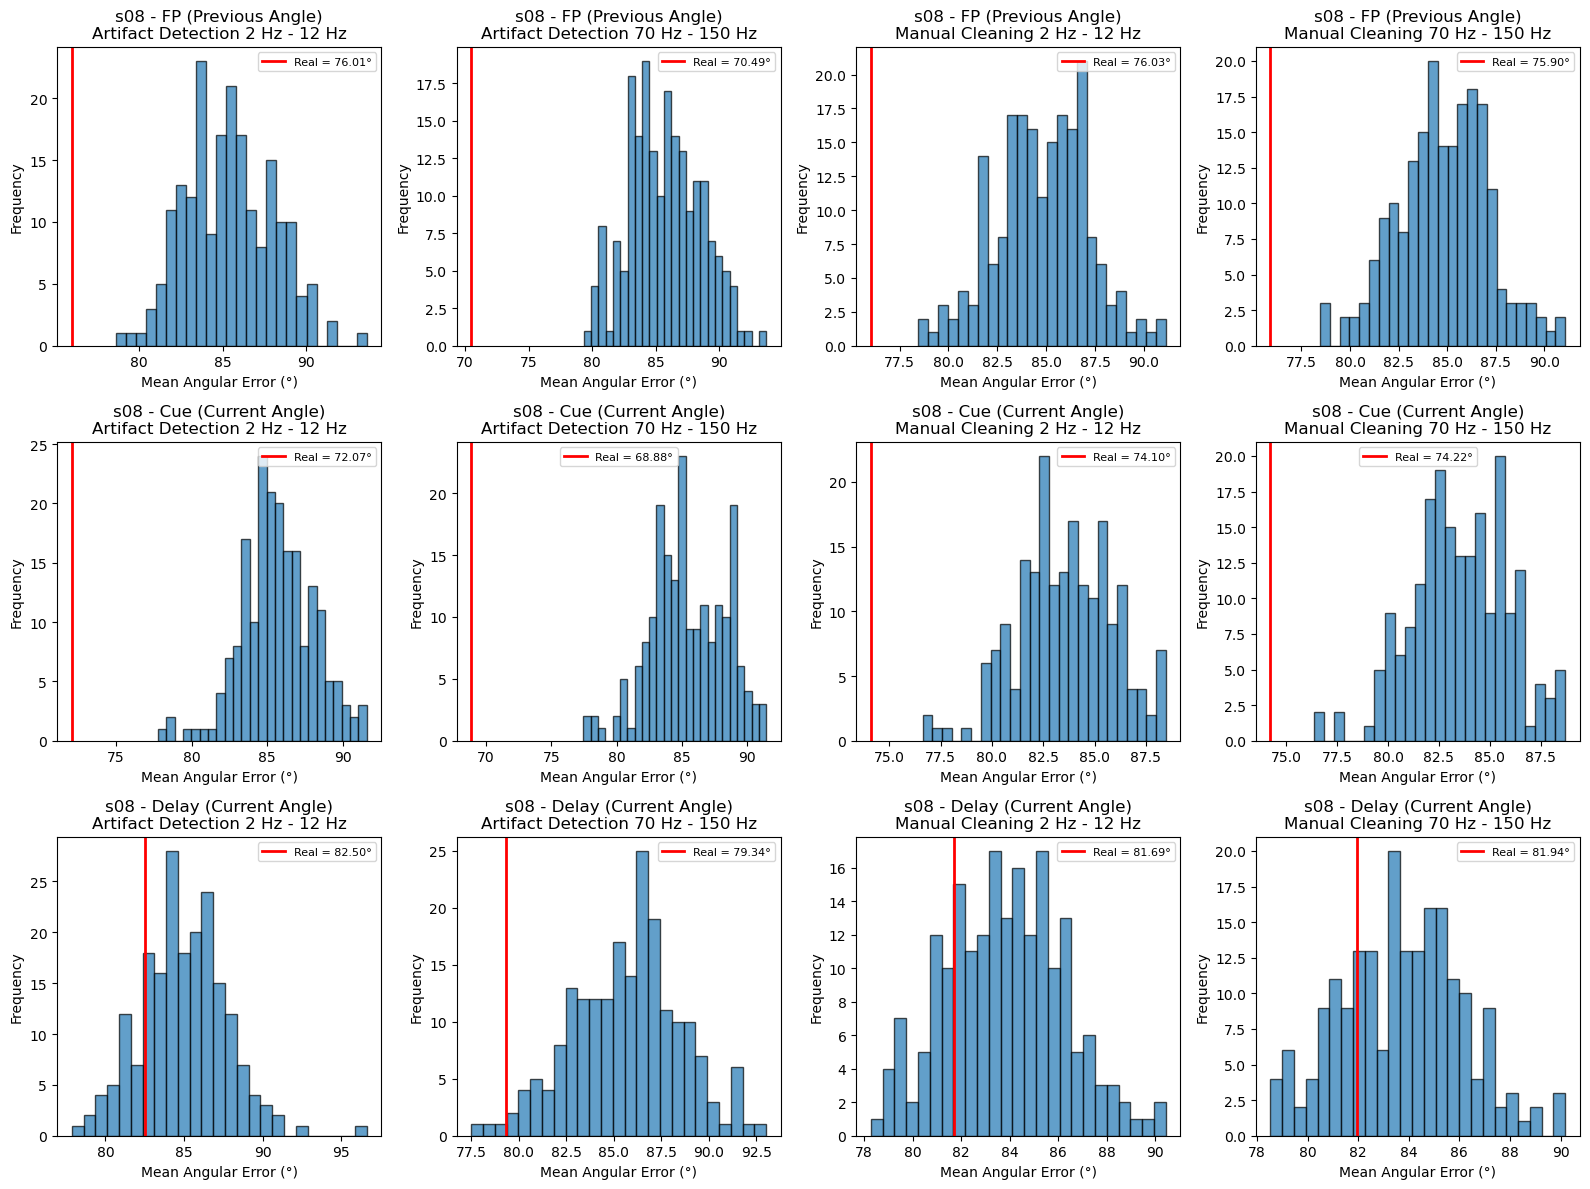

In [77]:
subject = "s08"

windows = {"FP": "fp", "Cue": "cue", "Delay": "delay"}

conditions = {
    "Artifact Detection 2 Hz - 12 Hz": results_art_2_12,
    "Artifact Detection 70 Hz - 150 Hz": results_art_70_150,
    "Manual Cleaning 2 Hz - 12 Hz": results_raw_2_12,
    "Manual Cleaning 70 Hz - 150 Hz": results_raw_70_150
}

fig, axs = plt.subplots(nrows=len(windows), ncols=len(conditions), figsize=(16, 12), squeeze=False)

for i, (win_label, win_key) in enumerate(windows.items()):

    if win_label.upper() == "FP":
        angle_type = "Previous Angle"
    else:
        angle_type = "Current Angle"
        
    for j, (cond_label, res_dict) in enumerate(conditions.items()):
        ax = axs[i, j]

        subj_res = res_dict.get(subject, {}).get(win_key, None)
        if subj_res is not None:
            null_errors = subj_res['null_errors']
            real_error = subj_res['real_error']
            ax.hist(null_errors, bins=25, alpha=0.7, edgecolor='k')
            ax.axvline(real_error, color='r', lw=2, label=f"Real = {real_error:.2f}°")
            ax.set_title(f"{subject} - {win_label} ({angle_type})\n{cond_label}")
            ax.set_xlabel("Mean Angular Error (°)")
            ax.set_ylabel("Frequency")
            ax.legend(fontsize=8)
        else:
            ax.text(0.5, 0.5, "No data", ha='center', va='center')
            ax.set_title(f"{subject} - {win_label} ({angle_type})\n{cond_label}")
plt.tight_layout()
plt.show()